# Analysis Processed Slocum Glider-AD2CP Data: RU29 2021 Mission 1

In [11]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
import cmocean.cm as cmo
import sys

## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
#sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'../src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [12]:
ds_id = 'ru29-20210630T1343-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.000000,18.170740,-64.831853,2021-06-30T13:43:52Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
1,NaN,18.170740,-64.831853,2021-06-30T13:43:57Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
2,0.000000,18.170740,-64.831853,2021-06-30T13:43:57Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
3,NaN,18.170740,-64.831853,2021-06-30T13:44:54Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
4,NaN,18.170465,-64.834150,2021-06-30T13:45:20Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
732984,0.238559,18.164417,-63.468548,2021-07-12T12:53:52Z,28.1624,5.63906,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732985,0.198799,18.164417,-63.468548,2021-07-12T12:53:54Z,28.1629,5.63894,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732986,0.178920,18.164417,-63.468548,2021-07-12T12:53:56Z,28.1619,5.63898,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732987,0.198799,18.164417,-63.468548,2021-07-12T12:53:58Z,28.1565,5.63899,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN


## Step 2: Load processed AD2CP data

In [24]:
dz=5

path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed_{}_meter_vertical_resolution/".format(dz)
#path = "/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/2021_Mission_1_Processed_Velocity_Profiles/"

files = np.sort(glob.glob(path+'*.csv'))

df = pd.concat(map(pd.read_csv, files))

df


,Unnamed: 0,inversion_u,inversion_v,inversion_depth,start_lon,start_lat,end_lon,end_lat,start_tm,end_tm,obs_per_bin
0,0,-0.147405,-0.003941,7.5,-64.831853,18.170740,-64.831477,18.167892,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z,725.0
1,1,-0.137927,0.000913,12.5,-64.831853,18.170740,-64.831477,18.167892,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z,2971.0
2,2,-0.102133,0.016083,17.5,-64.831853,18.170740,-64.831477,18.167892,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z,5332.0
3,3,-0.103387,0.046327,22.5,-64.831853,18.170740,-64.831477,18.167892,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z,6040.0
4,4,-0.090151,0.055770,27.5,-64.831853,18.170740,-64.831477,18.167892,2021-06-30T13:43:52Z,2021-06-30T14:30:55Z,5518.0
...,...,...,...,...,...,...,...,...,...,...,...
142,142,-0.072382,-0.011006,717.5,-64.368100,18.375202,-64.351020,18.387405,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z,561.0
143,143,-0.065223,-0.008906,722.5,-64.368100,18.375202,-64.351020,18.387405,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z,554.0
144,144,-0.067853,-0.007564,727.5,-64.368100,18.375202,-64.351020,18.387405,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z,530.0
145,145,-0.064472,-0.009557,732.5,-64.368100,18.375202,-64.351020,18.387405,2021-07-04T06:46:35Z,2021-07-04T09:09:35Z,917.0


In [25]:
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+dz,dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.NaN
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.NaN
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.NaN
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.NaN
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.NaN
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.NaN
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.NaN
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.NaN
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.NaN
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.NaN
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.NaN


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="Master/combined RU29 2021 Mission 1 AD2CP least-squares inversion velocity profile dataset"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
ds

<xarray.Dataset>
Dimensions:     (depth: 194, time: 113)
Coordinates:
  * time        (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
  * depth       (depth) float64 7.5 12.5 17.5 22.5 ... 957.5 962.5 967.5 972.5
Data variables:
    u_grid      (depth, time) float64 -0.1474 -0.1277 0.004686 ... nan nan nan
    v_grid      (depth, time) float64 -0.003941 0.02939 0.06964 ... nan nan nan
    latitude    (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    longitude   (time) float64 -64.83 -64.83 -64.81 ... -63.81 -63.82 -63.83
    start_lat   (time) float64 18.17 18.17 18.16 18.15 ... 18.15 18.15 18.15
    start_lon   (time) float64 -64.83 -64.83 -64.82 ... -63.8 -63.82 -63.83
    end_lat     (time) float64 18.17 18.16 18.15 18.14 ... 18.15 18.15 18.14
    end_lon     (time) float64 -64.83 -64.82 -64.8 ... -63.82 -63.83 -63.83
    start_time  (time) datetime64[ns] 2021-06-30T13:43:52 ... 2021-07-14T10:2...
    end_time    (time) datetime64[ns] 2021-06-30T14:30:55 ... 2021-07-14T11:1...
Attributes:
    description:  Master/combined RU29 2021 Mission 1 AD2CP least-squares inv...

## Now load the shear method results

In [1]:
# shear_dz = 5

# path = "/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/Processed_shear_{}_meter_vertical_resolution/".format(shear_dz)
# files = np.sort(glob.glob(path+'*.csv'))

# shear_df = pd.concat(map(pd.read_csv, files))


# shear_depth         = np.arange(np.min(shear_df.bin_new_shear),np.max(shear_df.bin_new_shear)+shear_dz,shear_dz)
# shear_depth         = np.flip(shear_depth)
# shear_time          = np.empty(len(files))
# shear_time[:]       = np.NaN
# shear_time          = shear_time.astype(pd.Timestamp)
# shear_start_time    = np.empty(len(files))
# shear_start_time[:] = np.NaN
# shear_start_time    = shear_time.astype(pd.Timestamp)
# shear_end_time      = np.empty(len(files))
# shear_end_time[:]   = np.NaN
# shear_end_time      = shear_time.astype(pd.Timestamp)
# shear_lat           = np.empty(len(files))
# shear_lat[:]        = np.NaN
# shear_lon           = np.empty(len(files))
# shear_lon[:]        = np.NaN
# shear_start_lat     = np.empty(len(files))
# shear_start_lat[:]  = np.NaN
# shear_start_lon     = np.empty(len(files))
# shear_start_lon[:]  = np.NaN
# shear_end_lat       = np.empty(len(files))
# shear_end_lat[:]    = np.NaN
# shear_end_lon       = np.empty(len(files))
# shear_end_lon[:]    = np.NaN
# u_grid = np.empty((len(shear_depth),len(files)))
# u_grid[:] = np.NaN
# v_grid = np.empty((len(shear_depth),len(files)))
# v_grid[:] = np.NaN
# u_grid_std = np.empty((len(shear_depth),len(files)))
# u_grid_std[:] = np.NaN
# v_grid_std = np.empty((len(shear_depth),len(files)))
# v_grid_std[:] = np.NaN



# ## Loop through by file, load in each file
# for x in np.arange(0,len(files)):
    
#     shear_df = pd.read_csv(files[x])
    
#     u_grid[np.arange(0,len(shear_df.U_shear_method.values)),x] = shear_df.U_shear_method.values
#     v_grid[np.arange(0,len(shear_df.V_shear_method.values)),x] = shear_df.V_shear_method.values
    
#     u_grid_std[np.arange(0,len(shear_df.U_prof_std.values)),x] = shear_df.U_prof_std.values
#     v_grid_std[np.arange(0,len(shear_df.V_prof_std.values)),x] = shear_df.V_prof_std.values


    
#     shear_start_time[x] = pd.to_datetime(shear_df.start_tm[0]).tz_localize(None)
#     shear_end_time[x] = pd.to_datetime(shear_df.end_tm[0]).tz_localize(None)
#     mid_time = shear_end_time[x]-shear_start_time[x]
    
#     shear_time[x] = shear_start_time[x]+mid_time

#     shear_start_lat[x] = shear_df.start_lat[0]
#     shear_start_lon[x] = shear_df.start_lon[0]
#     shear_end_lat[x]   = shear_df.end_lat[0]
#     shear_end_lon[x]   = shear_df.end_lon[0]
#     ## Lat/lon mid point
#     shear_lat[x]   = (shear_df.start_lat[0]+shear_df.end_lat[0])/2
#     shear_lon[x]   = (shear_df.start_lon[0]+shear_df.end_lon[0])/2


    
# ## Now stuff into an organized xarray dataset    
# shear_ds = xr.Dataset(
#     data_vars=dict(
#         u_grid     = (["depth", "time"], u_grid),
#         v_grid     = (["depth", "time"], v_grid),
#         u_grid_std = (["depth", "time"], u_grid_std),
#         v_grid_std = (["depth", "time"], v_grid_std),
        
#         latitude   = (["time"], shear_lat),
#         longitude  = (["time"], shear_lon),
#         start_lat  = (["time"], shear_start_lat),
#         start_lon  = (["time"], shear_start_lon),
#         end_lat    = (["time"], shear_end_lat),
#         end_lon    = (["time"], shear_end_lon),
#         start_time = (["time"], shear_start_time),
#         end_time   = (["time"], shear_end_time)
#     ),
#     coords=dict(
#         time  = shear_time,
#         depth = shear_depth
#     ),
#     attrs=dict(description="Master/combined RU29 2021 Mission 1 Nortek AD2CP shear method velocity profile dataset"),
# )

# ## Sort by time because files may not have in read in chronological order
# shear_ds = shear_ds.sortby(shear_ds.time)
# shear_ds



# Plot individual profiles from the two methods and save them to make a movie

In [2]:
# for x in np.arange(0,len(ds.time)):
#     fig = plt.figure(figsize=(8,10));
#     fig, (ax1, ax2) = plt.subplots(1, 2);
#     fig.patch.set_facecolor('white')

#     ## East-West Velocity
#     ax1.plot(ds.u_grid[:,x].values,ds.depth, color='tab:blue', linewidth=3, label='Inversion Method', linestyle='--')
#     ax1.plot(shear_ds.u_grid[:,x].values,-shear_ds.depth, color='tab:blue', linewidth=3, label='Shear Method')

#     ax1.fill_betweenx(-shear_ds.depth,
#                   shear_ds.u_grid[:,x].values-shear_ds.u_grid_std[:,x].values,
#                   shear_ds.u_grid[:,x].values+shear_ds.u_grid_std[:,x].values,
#                   facecolor='tab:blue',alpha=0.15)
#     ax1.set_xlim((-0.5,0.5))
#     ax1.set_xlabel('EW Velocity [m/s]')
#     ax1.set_ylabel('Depth [m]')
#     ax1.set_title('dz = {} meters\n{}\n{}'.format(dz, ds.time.values[x],shear_ds.time.values[x]))
#     ax1.legend(loc='lower right',prop={'size': 12})
#     ax1.grid(color = 'k', linestyle = '--', linewidth = 0.5)
#     ax1.invert_yaxis()

#     ## North-South Velocity
#     ax2.plot(ds.v_grid[:,x].values,ds.depth, color='tab:orange', linewidth=3, label='Inversion Method', linestyle='--')
#     ax2.plot(shear_ds.v_grid[:,x].values,-shear_ds.depth, color='tab:orange', linewidth=3, label='Shear Method')
#     ax2.fill_betweenx(-shear_ds.depth,
#                   shear_ds.v_grid[:,x].values-shear_ds.v_grid_std[:,x].values,
#                   shear_ds.v_grid[:,x].values+shear_ds.v_grid_std[:,x].values,
#                   facecolor='tab:orange',alpha=0.15)
#     ax2.set_xlim((-0.5,0.5))
#     ax2.set_xlabel('NS Velocity [m/s]')
#     ax2.set_title('dz = {} meters\n{}\n{}'.format(dz, ds.time.values[x],shear_ds.time.values[x]))
#     ax2.legend(loc='lower right',prop={'size': 12})
#     ax2.grid(color = 'k', linestyle = '--', linewidth = 0.5)
#     ax2.invert_yaxis()

#     plot_path_name = '/home/jg1200/Figures/RU29/RU29_2021_Mission_1/Inversion_Shear_Method_Comparison_Plots_dz_{}/profile_{}.png'.format(dz,x)
#     plt.savefig(plot_path_name,dpi=150)
#     plt.close()



## Make a map

/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


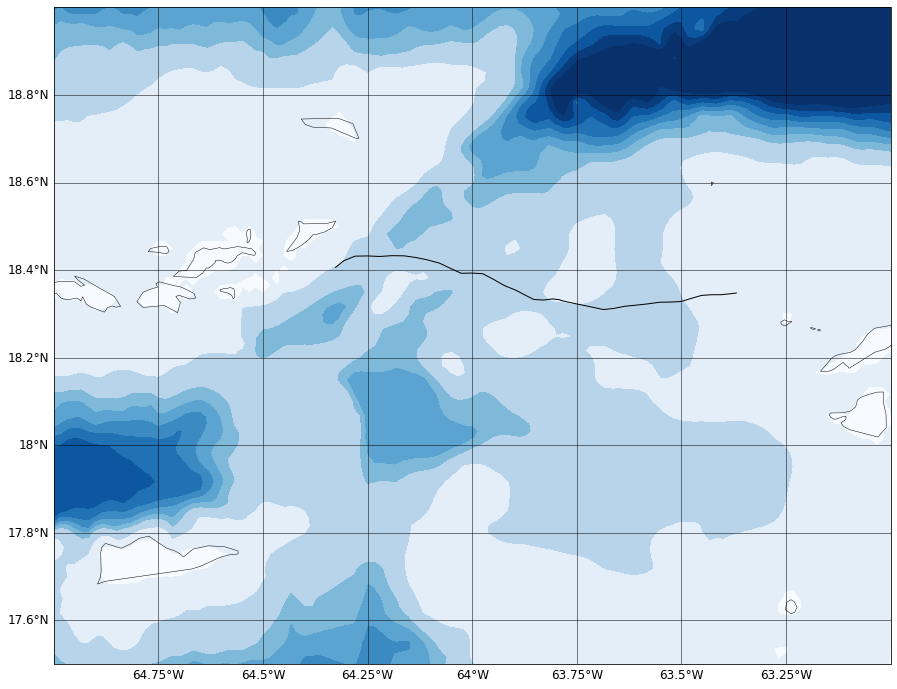

In [10]:
# grab bathymetry data for a map
import cartopy.crs as ccrs
lat_lims = [17.5, 19]
lon_lims = [-65, -63]

# grab some bathymetry
url = 'http://geoport.whoi.edu/thredds/dodsC/bathy/etopo1_bed_g2'

etopo1 = xr.open_dataset(url).sel(lat = slice(lat_lims[0], lat_lims[1]), lon = slice(lon_lims[0], lon_lims[1] ))

fig = plt.figure(figsize=(15,20))
ax = plt.subplot( projection= ccrs.Mercator())

## Good but too smooth
#dpth_contours = np.arange(-8500, 1, 500)
dpth_contours = np.append(np.arange(-5000, -2000, 500), np.arange(-2000, 1, 1000)) 

subset_ds = ds.sel(time=slice("2021-07-04 12:00:00","2021-07-09 23:59:00"))

plt.plot(subset_ds.longitude, subset_ds.latitude,linewidth=1, transform=ccrs.PlateCarree(),color='black')
#plt.plot(gdf_sect.longitude.values, gdf_sect.latitude.values,linewidth=1, transform=ccrs.PlateCarree(),color='red')


plt.contourf(etopo1.lon, etopo1.lat, etopo1.topo, dpth_contours, transform=ccrs.PlateCarree(), cmap='Blues_r', zorder=0,extend='both')
#plt.colorbar(label='Depth [m]',pad=0.03, fraction=0.055)
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color='black',linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

#plt.savefig('/Users/joegradone/Desktop/RU29_2021_Anegada_Map.png',dpi=300,facecolor='white')

## Anegada subset

In [11]:
subset_ds = ds.sel(time=slice("2021-07-04 12:00:00","2021-07-09 23:59:00"))

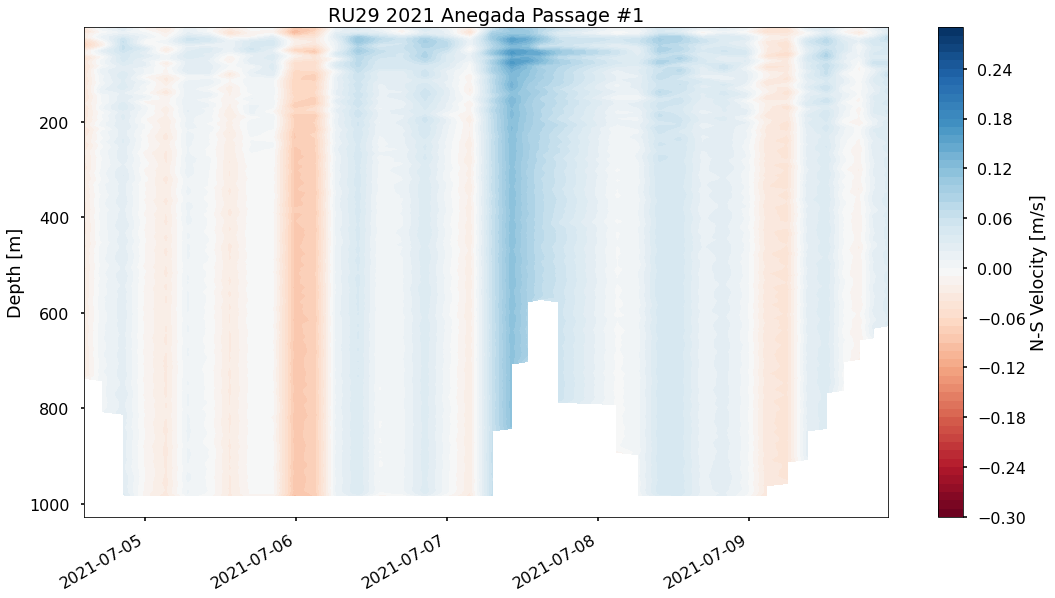

In [45]:
plt.figure(figsize=(18,10))
plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.v_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)

plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.colorbar(label='N-S Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #1')
plt.gcf().autofmt_xdate()

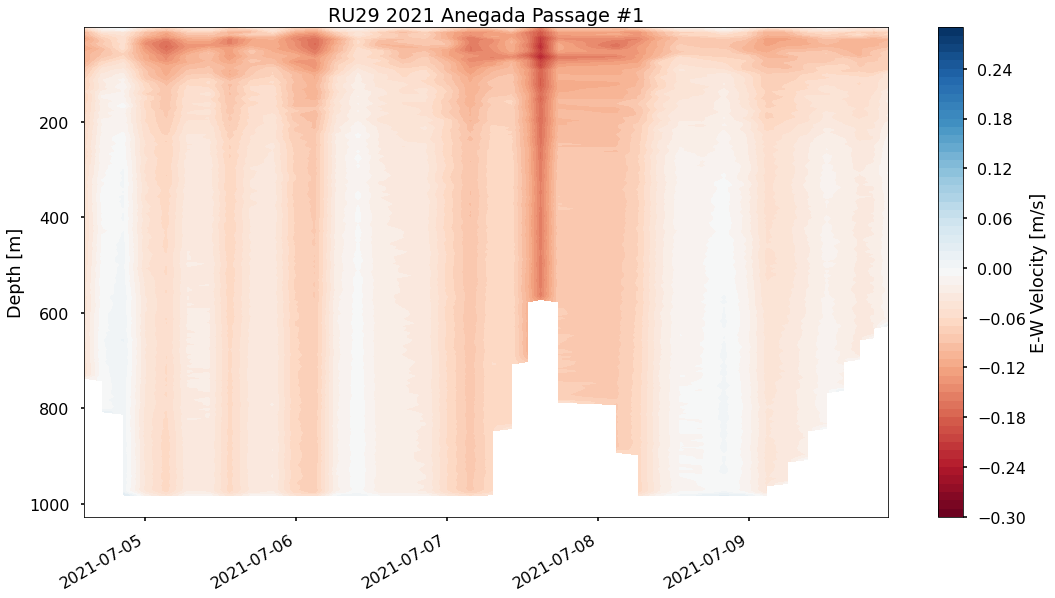

In [34]:
plt.figure(figsize=(18,10))
plt.contourf(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',levels=np.arange(-0.3,0.3,0.01))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,subset_ds.u_grid,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.colorbar(label='E-W Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #1')
plt.gcf().autofmt_xdate()

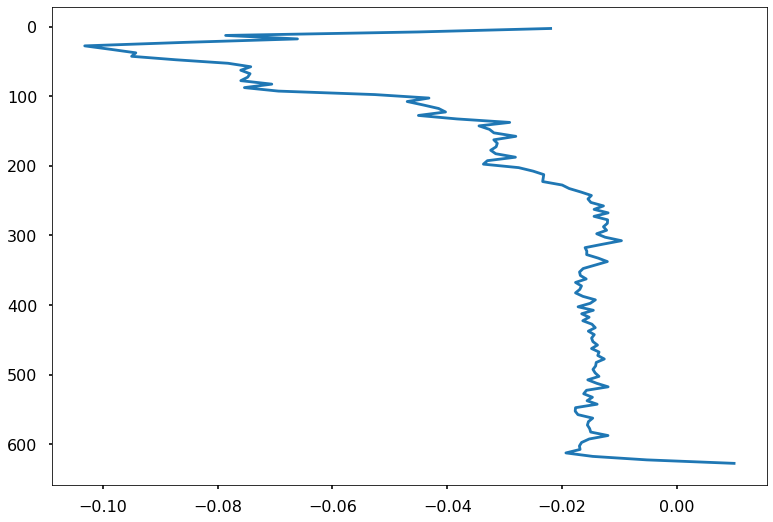

In [35]:
plt.plot(subset_ds.u_grid[:,-1],subset_ds.depth)
plt.gca().invert_yaxis()

## What do "transport" look like through this section?

### Need to do calculation with distance PER segment!

In [50]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(subset_ds.latitude.values[0])
lon1 = radians(subset_ds.longitude.values[0])
lat2 = radians(subset_ds.latitude.values[1])
lon2 = radians(subset_ds.longitude.values[1])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c *1000 # in meters

distance

3468.6191158795864

In [51]:
transport_u = (np.nansum(subset_ds.u_grid.values)*5*distance)/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
transport_v = (np.nansum(subset_ds.v_grid.values)*5*distance)/(10**6) # multiply by 5 because of grid cell size



In [52]:
transport_u

-6.317270134411659

In [53]:
transport_v

1.4283224660736953

## Testing rotating velocities by the orientation of the mouth of the Anegada Passage

In [36]:
along_vel = subset_ds.u_grid*np.cos(np.deg2rad(18))+subset_ds.v_grid*np.sin(np.deg2rad(18))
cross_vel = subset_ds.u_grid*np.sin(np.deg2rad(18))+subset_ds.v_grid*np.cos(np.deg2rad(18))

In [37]:
transport_along = (np.nansum(along_vel)*5*distance)/(10**6) # multiply by 5 because of grid cell size and distance must be the distance of one segment
transport_cross = (np.nansum(cross_vel)*5*distance)/(10**6) # multiply by 5 because of grid cell size


NameError: name 'distance' is not defined

In [ ]:
transport_along

In [38]:
transport_cross

NameError: name 'transport_cross' is not defined

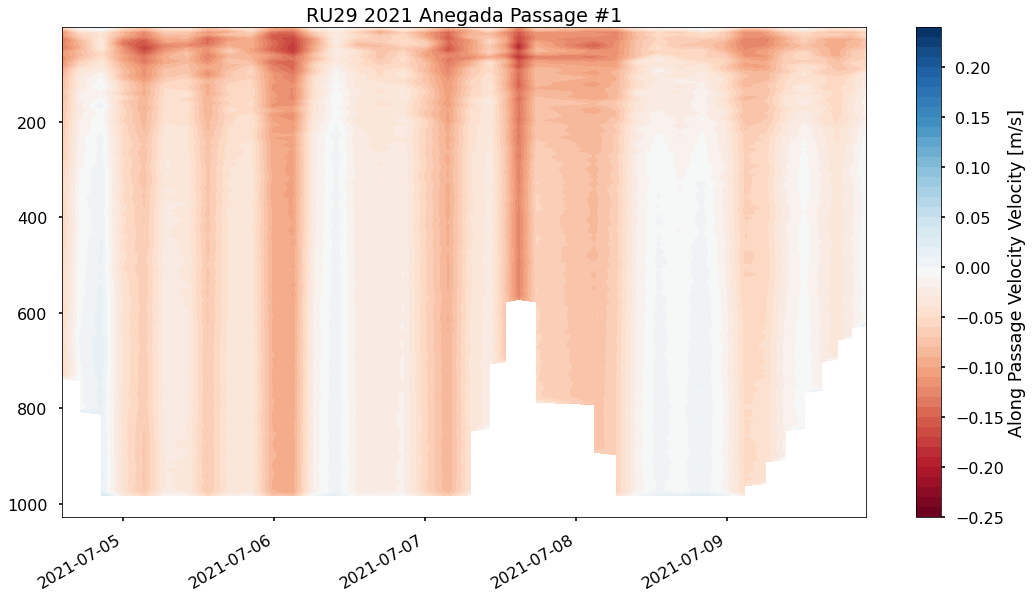

In [42]:
plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,along_vel,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.contourf(subset_ds.time,subset_ds.depth,along_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='Along Passage Velocity Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #1')
plt.gcf().autofmt_xdate()


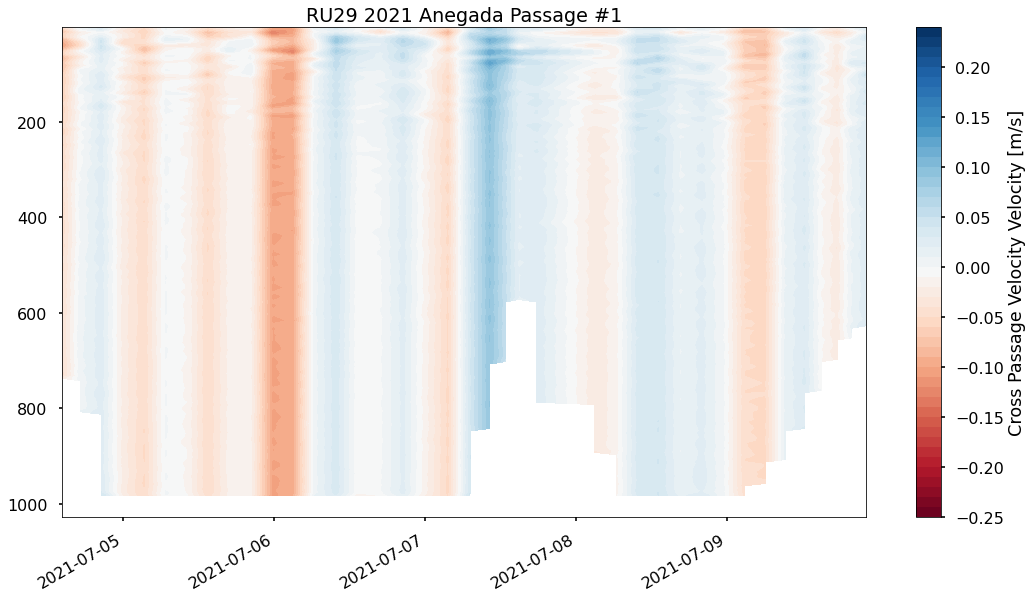

In [41]:
plt.figure(figsize=(18,10))
#plt.pcolormesh(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',vmin=-0.3,vmax=0.3)
plt.contourf(subset_ds.time,subset_ds.depth,cross_vel,cmap='RdBu',levels=np.arange(-0.25,0.25,0.01))
plt.gca().invert_yaxis()
plt.colorbar(label='Cross Passage Velocity Velocity [m/s]')
plt.title('RU29 2021 Anegada Passage #1')
plt.gcf().autofmt_xdate()